#### Name: Reda Mohsen Reda
#### ID: 18P5141
#### Course: Deep Learning
#### Topic: Hand Gesture Recognition Project

# Instal Dependencies

In [1]:
# !pip install tensorflow opencv-python matplotlib ipympl

# Import Libraries and Setup GPU

In [2]:
import os
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import random

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [26]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D, AveragePooling2D
from keras.layers import Flatten
from keras.layers import Dropout, Dense
from sklearn.metrics import confusion_matrix
import seaborn as sns


# About Data

[`hand-gesture-recognition-dataset`](https://www.kaggle.com/datasets/aryarishabh/hand-gesture-recognition-dataset?resource=download) This dataset contains total 24000 images of 20 different gestures. For training purpose, there are 900 images in each directory and for testing purpose there are 300 images in each directory.

![Full dataset](Images/dataset-cover.png)

# Load Data

 Loading the data into training dataset and testing dataset using tensorflow [`utils`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

In [5]:
batch_size = 16
img_height = 50
img_width = 50
class_names = ['0','1','2','3','4','5','6','7','8','9',
               '10','11','12','13','14','15','16','17',
               '18','19']

train_dataset = tf.keras.utils.image_dataset_from_directory(
    'dataset/train',
    labels='inferred',
    # label_mode='categorical',
    label_mode='int',
    color_mode='grayscale',
    class_names=class_names,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=1,
    validation_split=0.33335,
    subset='training'
)

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    'dataset/train',
    labels='inferred',
    # label_mode='categorical',
    label_mode='int',
    color_mode='grayscale',
    class_names=class_names,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=1,
    validation_split=0.33335,
    subset='validation'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    'dataset/test',
    labels='inferred',
    # label_mode='categorical',
    label_mode='int',
    color_mode='grayscale',
    class_names=class_names,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 18000 files belonging to 20 classes.
Using 12000 files for training.
Found 18000 files belonging to 20 classes.
Using 6000 files for validation.
Found 6000 files belonging to 20 classes.


if label_mode is categorical, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
if color_mode is grayscale, there's 1 channel in the image tensors.

In [6]:
class_names = train_dataset.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


# Normalize Data

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [9]:
normalized_train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Visualize Data

Images Shape (16, 50, 50, 1)
Labels Shape (16,)


Text(0.5, 1.0, '7')

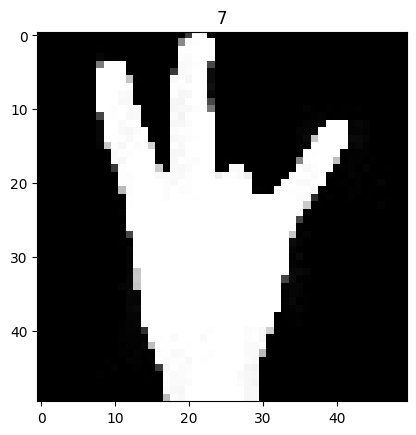

In [10]:
print('Images Shape', image_batch.shape)
print('Labels Shape', labels_batch.shape)
plt.imshow(image_batch[0],cmap='gray')
plt.title(class_names[labels_batch[0]])

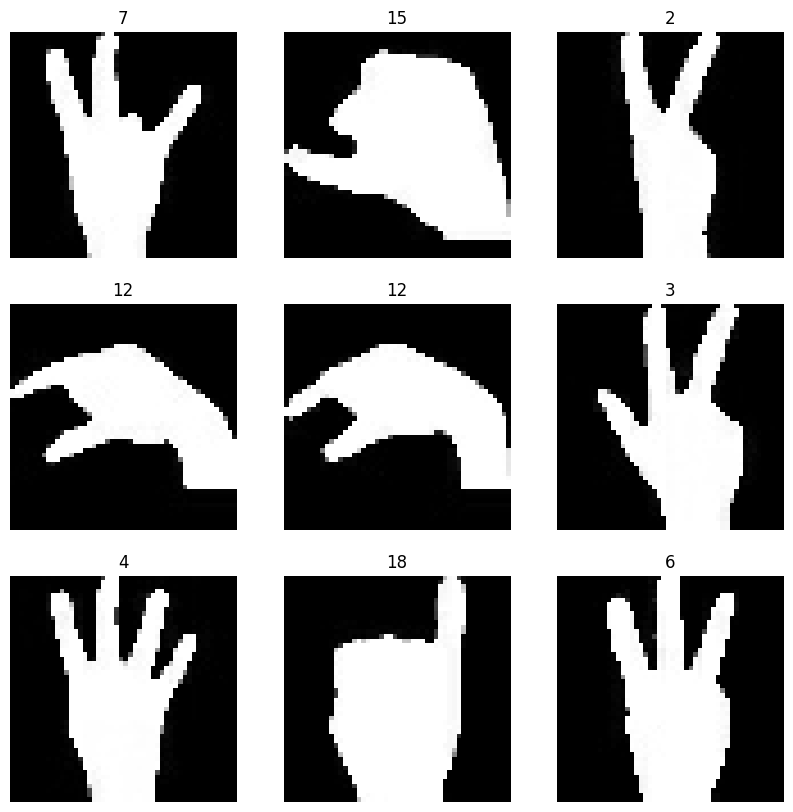

In [11]:
plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i],cmap='gray')
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

# Configure the dataset for performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = normalized_train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
valid_dataset = normalized_valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Build Deep Learning Model [Fully Connected Neural Network]

In [13]:
model = Sequential()
# Layer 1
model.add(Conv2D(filters=6, input_shape=(50,50,1), kernel_size=5, strides=1, activation='relu', padding="same")) #50x50x6
# Layer 2
model.add(MaxPool2D(strides=2)) # 25x25x6
# Layer 3
model.add(Conv2D(filters=16 ,kernel_size=3, strides=2, activation='relu', padding="valid")) # 12x12x16
# Layer 4
model.add(MaxPool2D(strides=2)) # 6x6x16
# Layer 5
model.add(Conv2D(filters=120,kernel_size=5,strides=1, activation='relu')) # 2x2x120
# Layer 6
model.add(MaxPool2D(strides=2)) # 1x1x120
# Flatten
model.add(Flatten())
# Dropout
model.add(Dropout(0.4))
# Layer 7
model.add(Dense(84, activation='relu'))
# Output Layer
model.add(Dense(20, activation='softmax'))

# Build the model
model.build()
# Compile the model
model.compile(loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(0.0001))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        880       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 120)         48120     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 120)        0

# Train

In [14]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [15]:
# To get total time of the training
# import time
# class CustomCallback(keras.callbacks.Callback):
#     def on_train_begin(self, logs=None):
#         self.now= time.time()
#     def on_train_end(self,totaltime, logs=None):
#         later=time.time()
#         duration=later-self.now 
#         totaltime = duration
#         print('Total Time is: ', totaltime, ' seconds')

In [16]:
epochs=50
# hist = model.fit(train_dataset, validation_data=valid_dataset, epochs=epochs, batch_size=batch_size, callbacks=[CustomCallback(),tensorboard_callback])
hist = model.fit(train_dataset, validation_data=valid_dataset, epochs=epochs, batch_size=batch_size, callbacks=[tensorboard_callback])

Epoch 1/50
750/750 [==============================] - 8s 8ms/step - loss: 1.3274 - accuracy: 0.6587 - val_loss: 0.0528 - val_accuracy: 0.9950
Epoch 2/50
750/750 [==============================] - 4s 5ms/step - loss: 0.1047 - accuracy: 0.9774 - val_loss: 0.0083 - val_accuracy: 0.9987
Epoch 3/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0399 - accuracy: 0.9916 - val_loss: 0.0040 - val_accuracy: 0.9992
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0207 - accuracy: 0.9959 - val_loss: 0.0020 - val_accuracy: 0.9992
Epoch 5/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0139 - accuracy: 0.9968 - val_loss: 9.6898e-04 - val_accuracy: 0.9998
Epoch 6/50
750/750 [==============================] - 3s 5ms/step - loss: 0.0121 - accuracy: 0.9972 - val_loss: 3.6009e-04 - val_accuracy: 1.0000
Epoch 7/50
750/750 [==============================] - 3s 4ms/step - loss: 0.0110 - accuracy: 0.9967 - val_loss: 4.7367e-04 - val_accuracy: 1

# Plot Performance

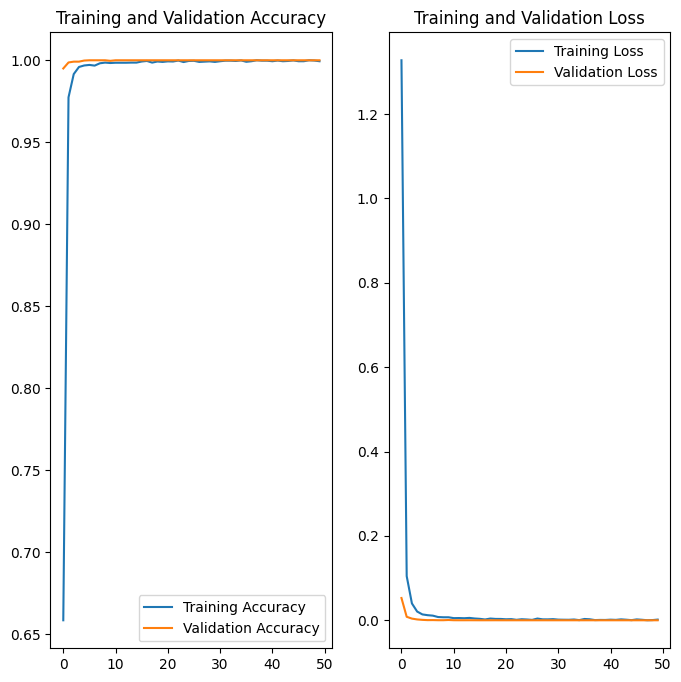

In [17]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate

In [18]:
print('\nEvaluating:')
(test_loss, test_accuracy) = model.evaluate(test_dataset)
print(f'\nTest accuracy: {test_accuracy * 100:>0.1f}%, Test loss: {test_loss:>8f}')


Evaluating:
375/375 [==============================] - 2s 4ms/step - loss: 0.2839 - accuracy: 0.9995

Test accuracy: 99.9%, Test loss: 0.283916


# Test

In [19]:
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))
# Retrieve a batch of images from the test set
test_image_batch, test_label_batch = next(iter(test_dataset))

In [20]:
predictions = model.predict(test_image_batch)
print('Predictions:\n', predictions)
print('Labels:\n', test_label_batch)

1/1 [==============================] - 0s 94ms/step
Predictions:
 [[2.24202140e-13 1.85790049e-20 9.28198953e-17 7.35166786e-21
  7.23492430e-15 1.24238524e-23 3.09477800e-20 1.72977761e-11
  1.00000000e+00 5.92253512e-19 1.36109784e-24 5.19428630e-13
  1.05565307e-18 7.68263106e-25 7.86592680e-18 7.03289465e-25
  1.42110184e-23 1.86062967e-14 7.92798354e-18 2.88599176e-21]
 [1.61325980e-10 7.06765734e-21 1.89982396e-16 1.00229298e-12
  1.63495631e-21 1.74460679e-13 4.16075198e-18 1.78666408e-20
  1.57881727e-16 3.82837928e-15 2.04931697e-11 9.56183049e-13
  1.08382860e-11 1.93390702e-22 6.29521368e-09 1.00000000e+00
  3.96872465e-11 3.42904025e-12 2.16728816e-13 1.36601249e-14]
 [1.76770133e-21 3.30995282e-22 8.22564396e-25 6.18349139e-17
  5.67931514e-32 3.56954385e-23 8.31544185e-38 1.80607051e-20
  3.57187833e-20 3.48333592e-21 8.19101043e-18 1.86749112e-22
  1.56945928e-19 1.08906751e-33 2.92956362e-27 3.89245508e-21
  3.53308672e-24 1.00000000e+00 1.65179421e-14 7.96593438e-19]
 

Text(0.5, 1.0, 'Predicted: 8, True: 8')

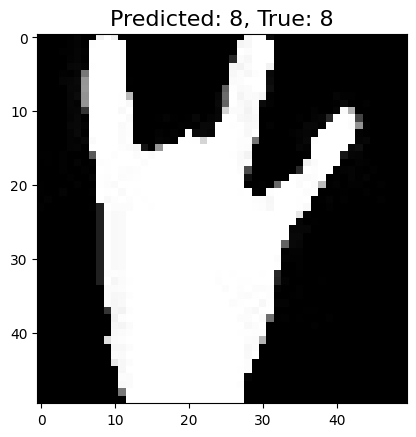

In [40]:
plt.imshow(test_image_batch[0], cmap='gray')
pred = np.argmax(predictions, axis=1)
plt.title("Predicted: {}, True: {}".format(pred[0], test_label_batch[0]), fontsize=16)

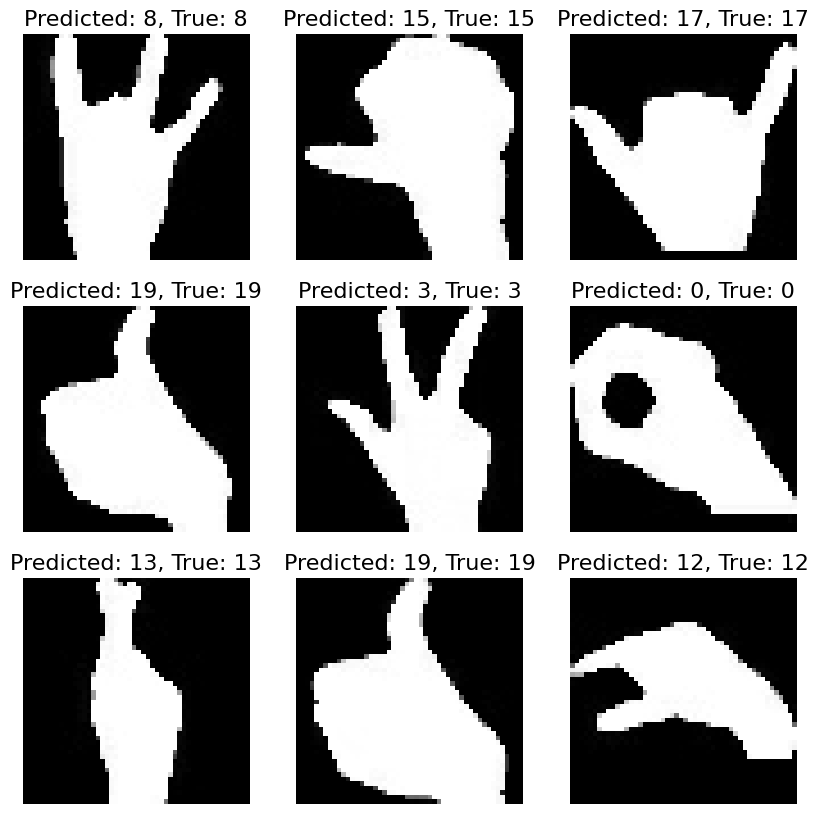

In [41]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_image_batch[i], cmap='gray')
    plt.title("Predicted: {}, True: {}".format(pred[i], test_label_batch[i].numpy()), fontsize=16)
    plt.axis("off")

# Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

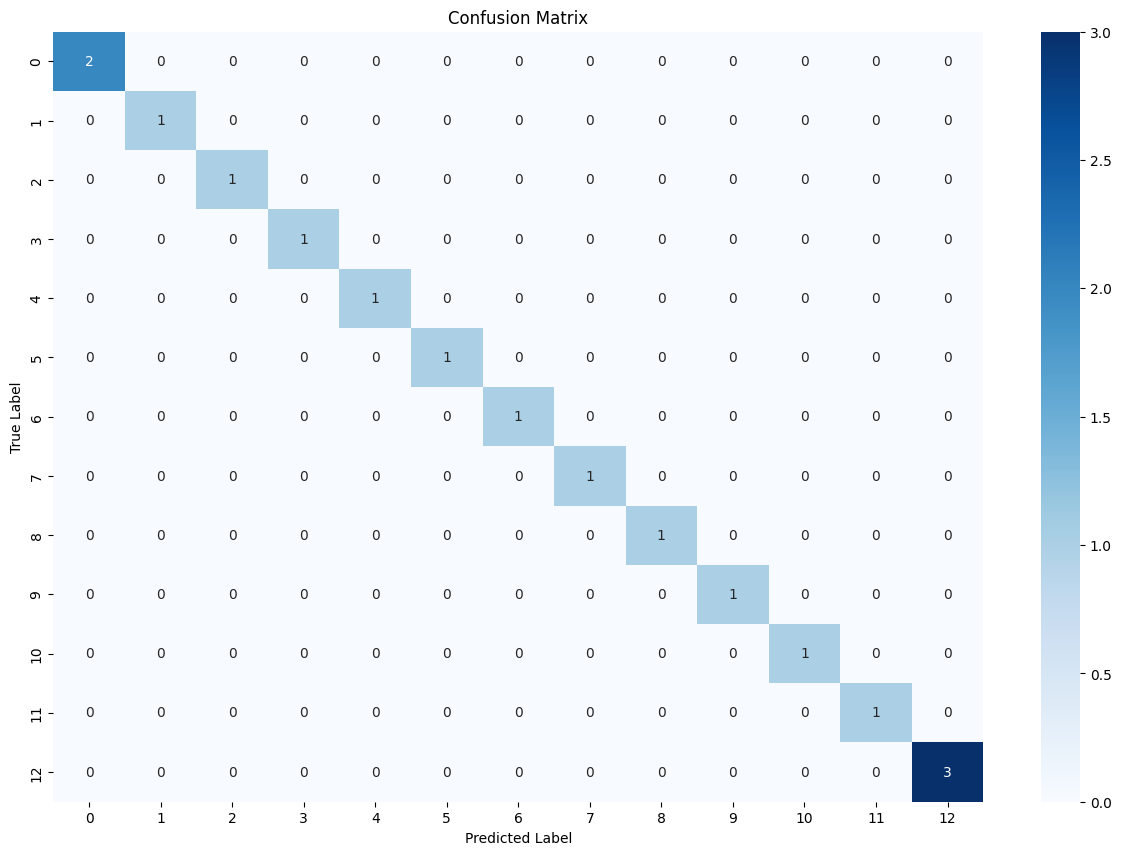

In [42]:
conf_matrix = confusion_matrix(test_label_batch, pred)

# Plot
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

# Save the Model

In [43]:
model.save('outputs/model')

INFO:tensorflow:Assets written to: outputs/model\assets


INFO:tensorflow:Assets written to: outputs/model\assets
